Marysa M. Laguë

2019.09.19

# ACDC "Weird World"

### Analysis of ISCA runs by Marianne Pietschnig 

#### Run descriptions:
<update this>

In [362]:
%matplotlib inline
import sys
sys.path.append('./scripts')

# netcdf/numpy/xarray
import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
from numpy import ma
from scipy import stats
import scipy.io as sio
import pickle as pickle
from sklearn import linear_model
import numpy.ma as ma
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing

import time

from copy import copy 

#from joblib import Parallel, delayed
import multiprocessing

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
#import brewer2mpl as cbrew
from matplotlib import ticker

from matplotlib.ticker import FormatStrFormatter

from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size

from mpl_toolkits.axes_grid1 import make_axes_locatable

# from matplotlib.gridspec import GridSpec
#import matplotlib.gridspec as gridspec
from matplotlib import gridspec

# OS interaction
import os
import sys
import cftime

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

#from season_mean import season_mean

import matplotlib.colors as mcolors

import glob

In [363]:
#%% Define NE_flux as a function

def NE_flux_zonal(lat, lon, FSNT, FLNT, area_grid, stats=None):
    # lat = vector of latitudes
    # lon = vector lof longitudes
    # FSNT = TOA shortwave [W/m2]
    # FLNT = TOA longwave [W/m2]
    # area = matrix for area weighting, optional
    # zonal_mean = tells if we want to average zonally, or do lon by lon.
    #               Default: lon by lon, returns array (vs vector)
    #
    # Assumes only one time slice is given (no time series, no 12 month things... modify this later to be more flexible)

    area = area_grid

    if stats == False:
        # Define toa energy imbalance/residual as shortwave - longwave
        # multiply by energy to work in clean watts
        Rtoa = (FSNT - FLNT) * area

        # spaces between lats and lons
        dlat = np.array(np.diff(lat))
        dlat = np.append(dlat, dlat[-1])
        dlon = np.array(np.diff(lon))
        dlon = np.append(dlon, dlon[-1])

        # create empty flux matrix to fill in
        flux = np.zeros([np.shape(lat)[0], np.shape(lon)[0]])

        # Loop over latitudes and sum energy
        for k in range(np.shape(lat)[0]):
            # sum energy of southern lats up to that lat
            for r in range(k):
                flux[k, :] = flux[k, :] + Rtoa[r, :]

        # calculate how much we overshot zero at the north pole
        imbal = flux[-1, :]
        imbal_mat = imbal / np.shape(lat)[0] * np.ones([np.shape(lat)[0], np.shape(lon)[0]])

        # modify Rtoa to account for discrete step sizes & overshoot
        Rtoa_mod = Rtoa - imbal_mat

        # re-calculate flux
        flux_mod = np.zeros([np.shape(lat)[0], np.shape(lon)[0]])
        for k in range(np.shape(lat)[0]):
            for r in range(k):
                flux_mod[k, :] = flux_mod[k, :] + Rtoa_mod[r, :]

        # Put back into W/m2 by dividing by area
        # NE_flux = flux_mod / area
        NE_flux = flux_mod * 10 ** (-15)

        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        ax = plt.gca()
        plt.plot(lat, NE_flux)
        ax.set_ylabel('NE Flux in PW')
        ax.set_xlabel('latitude')
        xlim = ax.get_xlim()
        xline = [xlim[0], xlim[1]]
        ylim = [0, 0]
        plt.plot([xlim[0], xlim[1]], [0, 0], linestyle='dashed', color='gray')
        plt.show()
        plt.close()

        # if zonal_mean == True:
        #     # average zonally, and divide through by area
        NE_flux_zonal = np.sum(NE_flux,1)
        # else:
        #     NE_flux_zonal = None

        # fig, axes = plt.subplots(1, 1, figsize=(5,5))
        # ax = plt.gca()
        # plt.plot(lat,NE_flux_zonal)
        # ax.set_ylabel('NE Flux in PW')
        # ax.set_xlabel('latitude')
        # xlim = ax.get_xlim()
        # xline = [xlim[0], xlim[1]]
        # ylim = [0,0]
        # plt.plot([xlim[0],xlim[1]], [0,0] ,linestyle='dashed',color='gray')
        # plt.show()
        # plt.close()

    # #
    # elif stats == True:
    #     # do std, dof, etc
    #     NE_flux = 'not defined yet!' # but a differnt shape this time
    # else:
    #     # otherwise give up, go home...
    #     NE_flux = 'specify stats'

    return NE_flux_zonal


In [364]:
#xr.set_options(enable_cftimeindex=True)


In [365]:
isca_outpath = '/Users/mlague/GoogleDrive/School/Research/ACDC/ISCA/'
case = 'half_ocean_newbucket_0qflux_control'

filelist = glob.glob(isca_outpath + case + '/*/*.nc')
filelist.sort()

In [366]:
with xr.set_options(enable_cftimeindex=True):
    ds_ctrl = xr.open_mfdataset(filelist,autoclose='true',decode_times=False)

time0 = ds_ctrl['time']
# time2 = nc.num2date(ds_ctrl['time'][:], units=ds_ctrl['time'].units,
#                             calendar=ds_ctrl['time'].calendar,only_use_cftime_datetimes=True)

time2 = cftime.num2date(ds_ctrl['time'][:], units=ds_ctrl['time'].units,
                            calendar=ds_ctrl['time'].calendar,only_use_cftime_datetimes=True)

ds_ctrl['time'].values = time2

# ds_spunup = ds_ctrl.sel()


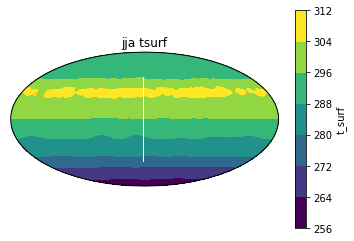

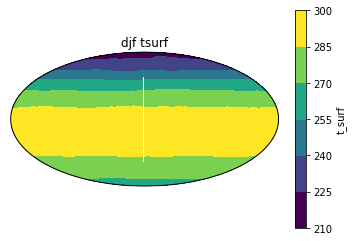

In [374]:
# ts_sea = ds_ctrl['t_surf'].groupby('time.season')
# data = ts_sea.sel(season='JJA')
#dict(ds_lib['rcp85']['albedo']['albedo'].groupby('time.season'))['SON'].values[:]
jja = dict(ds_ctrl['t_surf'].groupby('time.season'))['JJA'].mean('time')#.values[:]
djf = dict(ds_ctrl['t_surf'].groupby('time.season'))['DJF'].mean('time')#.values[:]


# plt.imshow(jja,clim=[240,300]);plt.colorbar();plt.title('JJA');plt.show();

# plt.imshow(djf,clim=[240,300]);plt.colorbar();plt.title('djf');plt.show();

ax = plt.axes(projection=ccrs.Mollweide())
jja.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),clim=[210,320])
ax.set_global()
# ax.title('jja tsurf')
# ax.coastlines()
plt.title('jja tsurf')
plt.show()

ax = plt.axes(projection=ccrs.Mollweide())
djf.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),clim=[210,320])
ax.set_global()
# ax.title('djf tsurf')
# ax.coastlines()
plt.title('djf tsurf')
plt.show()



KeyboardInterrupt: 

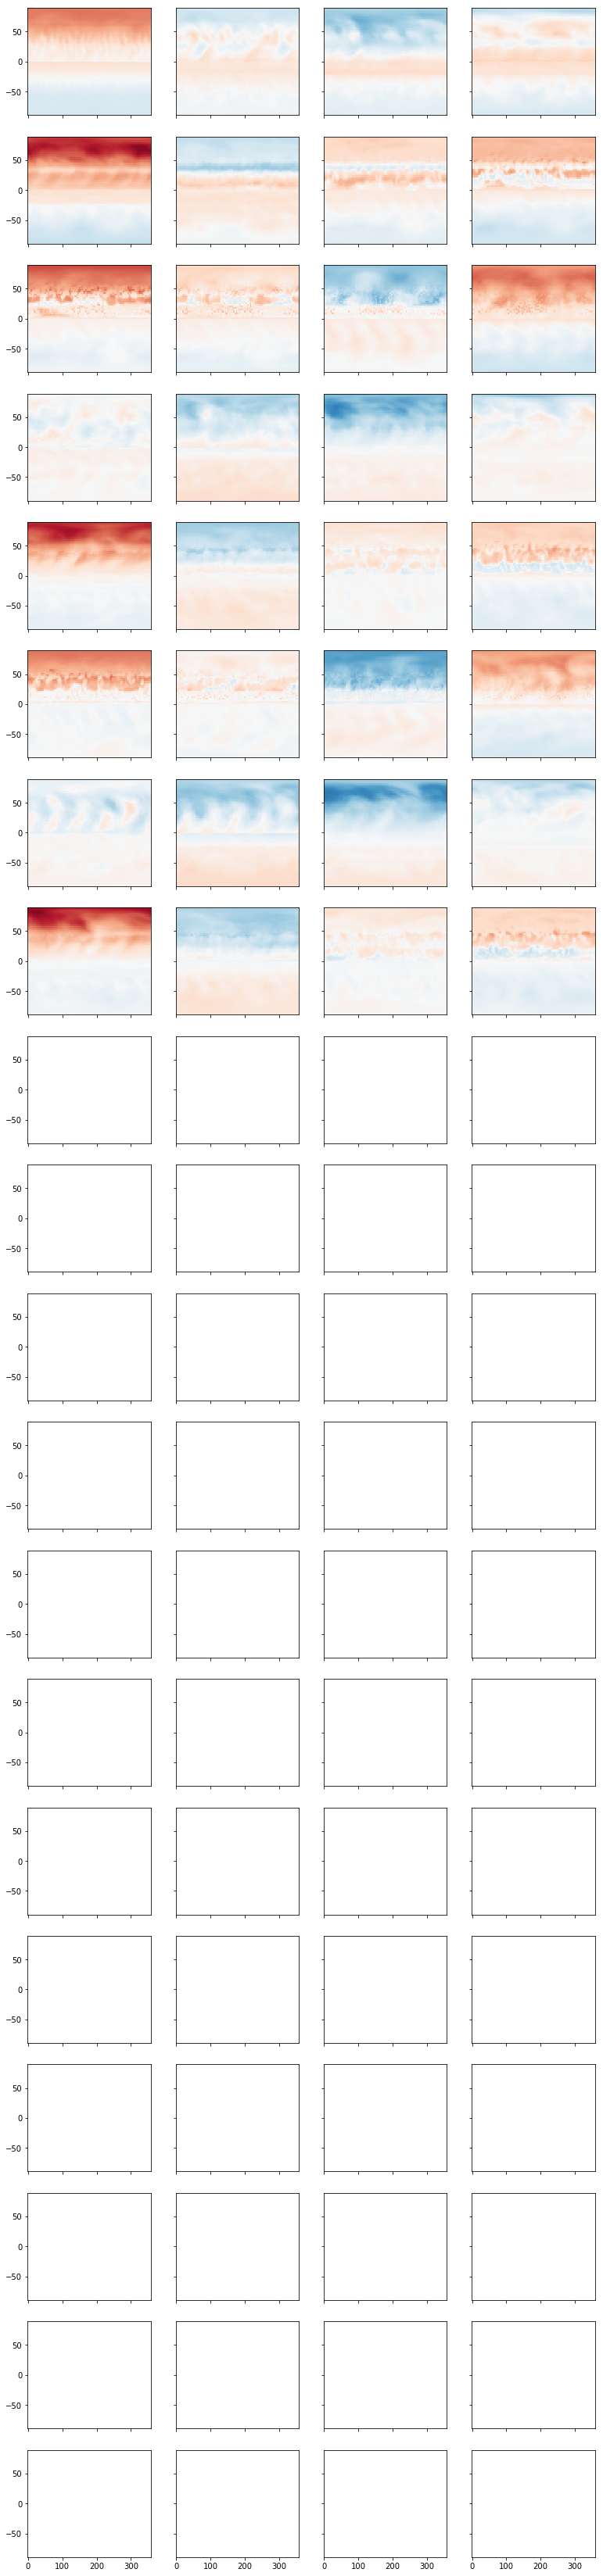

In [338]:
# anomalies.plot(col='time', col_wrap=4)

In [159]:
#ds_ctrl = xr.open_mfdataset(filelist,autoclose='true')

lat = ds_ctrl['lat'].values[:]
lon = ds_ctrl['lon'].values[:]
lev = ds_ctrl['pfull'].values[:]
time = ds_ctrl['time2']

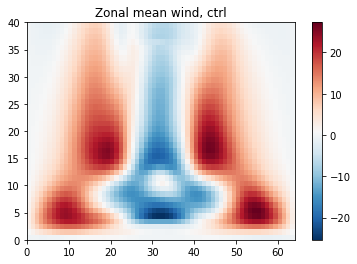

In [136]:
u_zonal = ds_ctrl['ucomp'].mean('lon').mean('time').values[:]
plt.pcolormesh(u_zonal,cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('Zonal mean wind, ctrl')

Difference between northerna and southern hemisphere zonal winds:

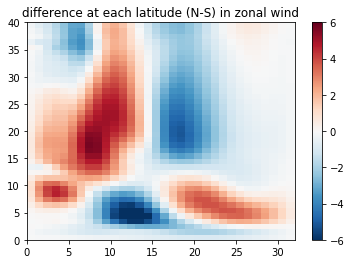

In [134]:
du = u_zonal[:,32:65] - np.fliplr(u_zonal[:,0:32])
plt.pcolormesh(du,cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.clim([-6,6])
plt.title('difference at each latitude (N-S) in zonal wind')

# add countours of zonal mean wind for NH ... or for SH

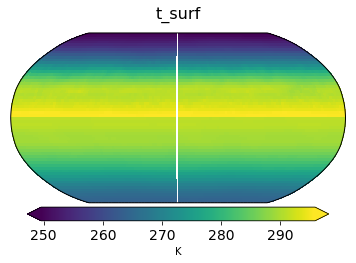

In [151]:
var = 't_surf'

mapdata = ds_ctrl[var].mean('time').values[:]


ax = plt.axes(projection=ccrs.Robinson())
#ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

LN,LT = np.meshgrid(lon,lat)

# cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
cs = plt.pcolormesh(LN,LT,mapdata,transform=ccrs.PlateCarree())

plt.set_cmap(copy(plt.cm.viridis))

plt.title(var,fontsize=16,y=1.05)
#plt.clim([240,300])

#     if clim:
#         plt.clim(clim)  
#         cs.set_clim(clim[0],clim[1])
#         cs.set_clim(clim)

cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(ds_ctrl[var].units)

#cbar.set_clim(clim)

cm = plt.get_cmap()




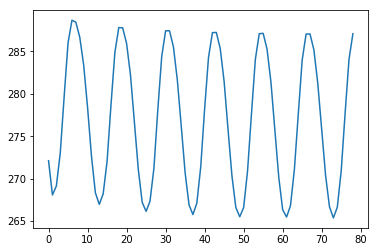

In [152]:
var = 't_surf'
t_ts = ds_ctrl[var].mean('lat').mean('lon')

plt.plot(t_ts)



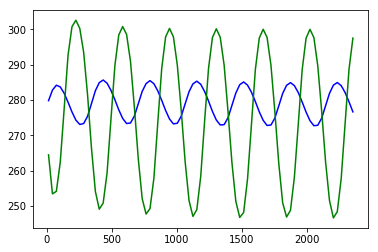

In [153]:
data = ds_ctrl[var].values[:]
NH_ts = np.mean(np.mean(data[:,32:65,:],2),1)
SH_ts = np.mean(np.mean(data[:,0:32,:],2),1)

plt.plot(time,SH_ts,'b',label='south')
plt.plot(time,NH_ts,'g',label='north')



In [154]:
data = ds_ctrl[var].mean('lon').
values[:]
NH_ts = np.mean(data[:,55,:],1)
SH_ts = np.mean(data[:,10,:],1)

plt.plot(time,SH_ts,'b',label='south')
plt.plot(time,NH_ts,'g',label='north')


SyntaxError: invalid syntax (<ipython-input-154-380fc9348aa2>, line 1)

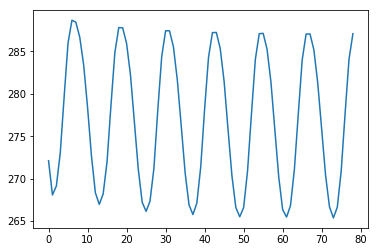

In [155]:
data = ds_ctrl['t_surf'].values[:]
data_ts = np.mean(np.mean(data,2),1)
plt.plot(data_ts)

Write function to calculate northwards energy flux from TOA net energy fluxes

NE flux:

In [308]:
# needs area of gridcell. 
# area_grid = 
#A =  (pi/180)R^2 |sin(lat1)-sin(lat2)| |lon1-lon2|
lat_a = np.insert(lat,0,-90.)
lat_a =  np.append(lat_a,90.) 

dlat = lat_a[1:-1] - lat_a[0:-2]

dlon = (lon[3]-lon[2])*np.ones(np.shape(lat))

earth_radius = 6371000  #meters
area_lat = np.pi/180. * earth_radius**2 * np.abs(np.sin(lat_a[1:-1]*np.pi/180.) - np.sin(lat_a[0:-2]*np.pi/180.)) / dlon

x = lon.size
y = lat.size
grid = np.ones([y,x])
area_grid = np.tile(area_lat,(x,1)).transpose()

total_area = np.sum(area_grid)